
# Learning Pandas using Enigma.io's API and datasets.

***

## Data exploration of NYC property assessment values (2010, 2014).

-------------
***Note***: Ideally I'd use multiple datasets from different sources that overlap a little, but that also augment each other.<br>That's what makes enigma particularly interesting, the simultaneous "normalized" access to datasets of different origins.  

But for now, baby learning Pandas steps, and start with the NYC property assessments dataset, which may allow us to do fun things such as being nosy and see how much the houses in our block have gained in value recently, and how many properties the Scottos own.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np



## Download the two datasets making use of enigma.io API.

Go to last cell in this notebook, which shows an initial version of a Python client to enigma.io.
To download a dataset, the module containing the client would be invoked like this...

     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2010
     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2014


## Taking too long to read the csv file into a Pandas DataFrame.

### What did we just download? Check-out file sizes, number of rows...


In [4]:
import os

num_lines_10 = !wc -l data/nyc_property_assessments/nyc.prop_assess_2010.csv
num_lines_14 = !wc -l data/nyc_property_assessments/nyc.prop_assess_2014.csv
print("Num lines 2010: {:,}".format(int(num_lines_10[0].split()[0])))
print("Num lines 2014: {:,}".format(int(num_lines_14[0].split()[0])))

print()

nyc_props_2010_fname = "data/nyc_property_assessments/nyc.prop_assess_2010.csv"
nyc_props_2014_fname = "data/nyc_property_assessments/nyc.prop_assess_2014.csv"
print("File size 2010: {:,}".format(os.stat(nyc_props_2014_fname).st_size))
print("File size 2014: {:,}".format(os.stat(nyc_props_2010_fname).st_size))


Num lines 2010: 1,060,513
Num lines 2014: 1,088,351

File size 2010: 164,461,696
File size 2014: 185,122,823


## So, file sizes of around 160MB for 2010 and 185MB for 2014.

#### Hmmm, importing these as Pandas DataFrames may thrash my humble laptop/VM.

#### Run some tests to get an idea about memory usage.<br>Do multiple read_csv(), increasing the number of rows read in each one.

See if memory consumption increases linearly.<br>Project mem usage for max number of rows.


***

## So, after running the script below, memory does increase linearly<br>(25kB/100 rows, 250kB/1kr ... 25MB/100krows).<br>For 1M rows, that'll be around 250MB RAM (per dataset). 

Playing with both full datasets/DataFrames simultaneously (2010 and 2014) will be a bit slow in my laptop.<br>Explore one dataset at a time to start with...

In [5]:
# Choose chunks of lines from different sections of the csv file
# so that they are not always from the beginning of the file.
# (just in case row sizes progressively increase/decrease/change)

# reminder: 2010 file: 700k lines
from collections import OrderedDict

dfs_info = OrderedDict()
dfs_info[100]  = dict(numrows=100,  rowstart=1024*1)
dfs_info[1000] = dict(numrows=1000, rowstart=1024*10)
dfs_info[10000] = dict(numrows=10000, rowstart=1024*100)
dfs_info[100000] = dict(numrows=100000, rowstart=1024*500)

for df_info in dfs_info.values():
    numrows, rowstart = df_info["numrows"], df_info["rowstart"]
    df_info["df"] = pd.read_csv(nyc_props_2010_fname, header=0,
                                skiprows=range(1,rowstart+1), nrows=numrows)
    print("\n\n"
          "====> Data frame info (for {:,} rows)\n"
          "=======> (check the last line: 'memory usage')".format(numrows))
    df_info["df"].info()


# won't need previous test DataFrames - indicate that we can free that memory...
del dfs_info




====> Data frame info (for 100 rows)
=======> (check the last line: 'memory usage')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 32 columns):
bble        100 non-null int64
borough     100 non-null object
block       100 non-null int64
lot         100 non-null int64
easement    0 non-null float64
owner       36 non-null object
bldgcl      100 non-null object
taxclass    100 non-null object
ltfront     100 non-null int64
ltdepth     100 non-null int64
ext         0 non-null float64
stories     100 non-null int64
fullval     100 non-null float64
avland      100 non-null float64
avtot       100 non-null float64
exland      100 non-null float64
extot       100 non-null float64
excd1       98 non-null float64
staddr      100 non-null object
zip         99 non-null float64
exmptcl     0 non-null float64
bldfront    100 non-null int64
blddepth    100 non-null int64
avland2     99 non-null float64
avtot2      99 non-null float64
exland2     98 no

/home/jds/.pyvenvs/liveresume/lib/python3.4/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


***
## Let's start by using a subset of the 2010 csv file to explore the schema.<br>Select all rows where the zip code is 11231 (Carroll Gardens, Brooklyn).

#####Use the linux csvgrep util to select zip cols that match 11231.

In [6]:
props_2010_11231_fname = "data/nyc_property_assessments/2010_zip11231.csv"

if not os.path.exists(props_2010_11231_fname):
    print("Creating 11231 csv file...")
    !csvgrep -c zip -r "11231" data/nyc_property_assessments/nyc.prop_assess_2010.csv > data/nyc_property_assessments/props_2010_zip11231.csv


##Start exploring the data/schema.

In [7]:
df10_11231 = pd.read_csv(props_2010_11231_fname)

### Confirm we filtered correctly. Also, how many rows/properties in 11231? 

In [8]:
print("df.shape: ", df10_11231.shape)
print("Confirm we filtered correctly. Num rows where zip==11231: ", 
      len(df10_11231.zip == 11231))


df.shape:  (6260, 32)
Confirm we filtered correctly. Num rows where zip==11231:  6260


###OK, generating a subset csv file is useful. Let's make it a more generic util func.

Pass in a colname ("zip") and a pattern we want to match (11231),
and create a new subset csv file, matching the search criteria.

In [9]:
import os
def create_subset_csv(colname, regex_str, orig_csv_fname, new_csv_fname=None):
    assert os.path.exists(orig_csv_fname)
    
    if not new_csv_fname:
        orig_split = os.path.split(orig_csv_fname)
        new_csv_fname = "{col}_{reg}__{orig}".format(
            col=colname, reg=regex_str, orig=orig_split[-1])
        new_full_name = os.path.join(orig_split[0], new_csv_fname)

    if not os.path.exists(new_full_name):
        os.system('csvgrep -c {col} -r "{reg}" {orig} > {new}'.format(
            col=colname, reg=regex_str, orig=orig_csv_fname, new=new_full_name))
    return new_full_name


In [10]:
# let's use it to re-generate the 11231 zip subset 
# and confirm via df.info() that the result is equivalent...
new_fname = create_subset_csv("zip", "11231", 
                              "data/nyc_property_assessments/nyc.prop_assess_2010.csv")

df10_zip11231 = pd.read_csv(new_fname)
df10_zip11231.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6260 entries, 0 to 6259
Data columns (total 32 columns):
bble        6260 non-null float64
borough     6260 non-null object
block       6260 non-null int64
lot         6260 non-null int64
easement    5 non-null object
owner       6087 non-null object
bldgcl      6260 non-null object
taxclass    6260 non-null object
ltfront     6260 non-null int64
ltdepth     6260 non-null int64
ext         474 non-null object
stories     5744 non-null float64
fullval     6260 non-null float64
avland      6260 non-null float64
avtot       6260 non-null float64
exland      6260 non-null float64
extot       6260 non-null float64
excd1       2823 non-null float64
staddr      6260 non-null object
zip         6260 non-null int64
exmptcl     180 non-null object
bldfront    6260 non-null int64
blddepth    6260 non-null int64
avland2     1991 non-null float64
avtot2      1991 non-null float64
exland2     533 non-null float64
extot2      786 non-null float64
excd

## Cool, that worked. Some cleanup from previous work above...

In [11]:
# some cleanup; delete previous dataframes that we won't use anymore
# frees mem and prevents inadvertent references to them in subsequent cells (guilty!)
del props_2010_11231_fname
del df10_11231

## Some data exploration...

### What are the columns?

In [12]:
df10_zip11231.columns

Index(['bble', 'borough', 'block', 'lot', 'easement', 'owner', 'bldgcl', 'taxclass', 'ltfront', 'ltdepth', 'ext', 'stories', 'fullval', 'avland', 'avtot', 'exland', 'extot', 'excd1', 'staddr', 'zip', 'exmptcl', 'bldfront', 'blddepth', 'avland2', 'avtot2', 'exland2', 'extot2', 'excd2', 'period', 'year', 'valtype', 'serialid'], dtype='object')

### Make the column info more visually friendly.

In [13]:
# Column names not that visually clear; make them easier to read...
def prettify_colnames(df, cols_per_row=7):
    cols = sorted(df.columns)
    colsize = 2 + max(len(colname) for colname in cols)
    outstr = ""
    for ix, colname in enumerate(cols):
        outstr += "{nl}{cn:{sz}}".format(
            nl = "" if (ix+1) % cols_per_row else "\n", cn=colname, sz=colsize)
    return outstr

# try again...
print("\nColumn names...\n\n{}".format(prettify_colnames(df10_zip11231, 6)))


Column names...

avland    avland2   avtot     avtot2    bble      
blddepth  bldfront  bldgcl    block     borough   easement  
excd1     excd2     exland    exland2   exmptcl   ext       
extot     extot2    fullval   lot       ltdepth   ltfront   
owner     period    serialid  staddr    stories   taxclass  
valtype   year      zip       


## What do these column headers mean!? Kind of cryptic names...

### Navigate enigma.io website. <br>You can click on "Description" for any table/dataset.<br>A modal window pops up.<br> You can choose to "export" the column descriptions as a file.


Downloaded it, unzipped it. It contains 2 files...

     table-info.csv
     column-info.csv
     

### Read the column-info.csv file.

In [14]:
colinfo_df = pd.read_csv("data/nyc_property_assessments/2010-column-info.csv")
colinfo_df.head()

,Column Name,Column Description,Column API ID,Column Type
0,Year,Year,year,type_varchar
1,BBLE,"Concatenation of Borough, Block, Lot, & Easement",bble,type_varchar
2,Owner,Owner,owner,type_varchar
3,Street Address,Street Address,staddr,type_varchar
4,Block,Valid Block Ranges By Borough: Manhattan - [1 ...,block,type_varchar


In [15]:
# peek
colinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 4 columns):
Column Name           32 non-null object
Column Description    32 non-null object
Column API ID         32 non-null object
Column Type           32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB


In [16]:
print("number of cols in dataset: ", len(df10_zip11231.columns))
print("number of columns described in the column-info file: ", colinfo_df.shape[0])

number of cols in dataset:  32
number of columns described in the column-info file:  32


### Cool, every column in the dataset is described!

In [17]:
# display description for all cols
pd.set_option("max_rows", 50)
colinfo_df.ix[:, ["Column API ID", "Column Description", "Column Type"]].sort("Column API ID")


,Column API ID,Column Description,Column Type
8,avland,Actual Land Value,type_numeric
26,avland2,Transitional Land Value,type_numeric
9,avtot,Actual Total Value,type_numeric
27,avtot2,Transitional Total Value,type_numeric
1,bble,"Concatenation of Borough, Block, Lot, & Easement",type_varchar
25,blddepth,Building Depth in Feet,type_numeric
24,bldfront,Building Frontage in Feet,type_numeric
14,bldgcl,Building Class - See form listing a descriptio...,type_varchar
4,block,Valid Block Ranges By Borough: Manhattan - [1 ...,type_varchar
13,borough,[1] - Manhattan [2] - Bronx [3] - Brooklyn [4]...,type_varchar


In [18]:
# Reminder of what the real data looks like, also w/ cols sorted alphab.
pd.set_option('max_columns', 50)
df10_zip11231.head().ix[:, sorted(df10_zip11231.columns)]


,avland,avland2,avtot,avtot2,bble,blddepth,bldfront,bldgcl,block,borough,easement,excd1,excd2,exland,exland2,exmptcl,ext,extot,extot2,fullval,lot,ltdepth,ltfront,owner,period,serialid,staddr,stories,taxclass,valtype,year,zip
0,0,NaN,0,NaN,3004097502,0,0,R0,409,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,7502,100,20,NaN,FINAL,246026,91 DOUGLASS STREET,NaN,2,AC-TR,2009/10,11231
1,267,267,3498,2563,3004211044,0,0,R5,421,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,7774,1044,0,0,NaN,FINAL,246896,344 DE GRAW STREET,NaN,4,AC-TR,2009/10,11231
2,0,NaN,0,NaN,3004217501,44,107,R0,421,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,7501,100,125,NaN,FINAL,247042,344 DE GRAW STREET,6,2,AC-TR,2009/10,11231
3,0,NaN,0,NaN,3003190009,0,0,D7,319,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,9,97,19,POSTGRADUATE CNTR MEN,FINAL,256645,169 COLUMBIA STREET,NaN,2,AC-TR,2009/10,11231
4,0,NaN,0,NaN,3003367502,0,0,R0,336,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,7502,100,61,NaN,FINAL,256719,156 SACKETT STREET,6,2,AC-TR,2009/10,11231


### Select what seems like a useful subset of the 32 columns.<br> We'll use this col subset for our data exploration.

In [19]:
# these columns seem interesting 
# (owner, street name & number, value, lot front/depth in ft., num of stories, ...)
colnames_10 = ['owner',
               'fullval',
               'zip',
               'staddr',
               'ltfront',
               'ltdepth',
               'stories',
               'easement']

colnames_10.append('taxclass')
#############
### note from the future!!
### it turns out that the "taxclass" columns is useful...
#############
#
# had to go fishing for info re: tax class to see if it may be
# a relevant column. it will be, to distinguish between residential
# vs. rental vs. utility vs ...
#
# http://www1.nyc.gov/site/finance/taxes/definitions-of-property-assessment-terms.page
#
#####
#
## Tax Class:  Property in NYC is divided into 4 classes:
##
## - Class 1: Most residential property of up to three units (family
##     homes and small stores or offices with one or two apartments
##     attached), and most condominiums that are not more than three
##     stories.
##
## - Class 2: All other property that is not in Class 1 and is
##       primarily residential (rentals, cooperatives and
##       condominiums). Class 2 includes:
##   * Sub-Class 2a  (4 -  6 unit rental building);
##   * Sub-Class 2b  (7 - 10 unit rental building);
##   * Sub-Class 2c  (2 - 10 unit cooperative or condominium); and
##   * Class 2  (11 units or more).
##
## - Class 3: Most utility property.
##
## - Class 4: All commercial and industrial properties, such as
##     office, retail, factory buildings and all other properties not
##     included in tax classes 1, 2 or 3.
##
######



# index the descr table by the API name...
cidx10 = colinfo_df.set_index("Column API ID")

# map the cryptic dataset colnames to a more user-friendly name
# (preserve the col order listed above)
from collections import OrderedDict
cols_subset = OrderedDict()
for cn in colnames_10:
    cols_subset[cn] = cidx10.ix[cn]["Column Name"].strip()

# rename cols of interest
#tmp_renamed = df10_zip11231.rename(columns = cols_subset)
df10_zip11231_subcols = df10_zip11231.rename(columns = cols_subset)

# and drop all other cols
all_cols = set(df10_zip11231.columns)
df10_zip11231_subcols = df10_zip11231_subcols.drop(all_cols - set(cols_subset.keys()), axis=1)
df10_zip11231_subcols = df10_zip11231_subcols.reindex_axis(cols_subset.values(), axis=1)

In [20]:
df10_zip11231_subcols.columns

Index(['Owner', 'Full Value', 'Zip', 'Street Address', 'Lot Frontage', 'Lot Depth', 'Stories', 'Easement', 'Tax Class'], dtype='object')

In [21]:
# let's try these new column names, should make table easier to decode.
df10_zip11231_subcols.ix[100:105]

,Owner,Full Value,Zip,Street Address,Lot Frontage,Lot Depth,Stories,Easement,Tax Class
100,SOUTH BKLYN RENEWALAS,630000,11231,149 COLUMBIA STREET,26,76,4,NaN,2B
101,ZAHA AHMAD,841000,11231,147A COLUMBIA STREET,18,97,4,NaN,2B
102,ZAHA T AHMAD,548000,11231,147 COLUMBIA STREET,18,97,4,NaN,2B
103,JACK L. IRWIN,665000,11231,145 COLUMBIA STREET,19,97,4,NaN,2A
104,SOUTH BKLYN RENEWALAS,581000,11231,143 COLUMBIA STREET,19,97,4,NaN,2B
105,"CASANOVA, SAHYLI",1193000,11231,139 COLUMBIA STREET,18,97,3,NaN,1


In [22]:
# let's put the new (long-named) columns in a list so that
# we don't have to type them every time...
cols_to_show = list(cidx10.ix[colnames_10]['Column Name'])
cols_to_show

['Owner',
 'Full Value',
 'Zip',
 'Street Address',
 'Lot Frontage',
 'Lot Depth',
 'Stories',
 'Easement',
 'Tax Class']

## OK, enough column cleanup for now. Explore the table's contents.

## Delete the subset dataframe that we used to investigate the columns.<br>And go for it, read the full 2010 dataset.

In [23]:
%%time

del df10_zip11231
del df10_zip11231_subcols

# col 0 ("bble") is generating warnings during the read (mixed dtypes). Be specific.
df2010 = pd.read_csv(nyc_props_2010_fname, dtype={'bble': object})

CPU times: user 4.4 s, sys: 5.96 s, total: 10.4 s
Wall time: 10.4 s


### And do the column reduction + renaming.

In [24]:
# rename cols of interest; drop all others; reindex
all_cols = set(df2010.columns)
df2010_subcols = df2010.rename(columns = cols_subset)
df2010_subcols = df2010_subcols.drop(all_cols - set(cols_subset.keys()), axis=1)
df2010_subcols = df2010_subcols.reindex_axis(cols_subset.values(), axis=1)

del df2010

###From the 2010 df.info() below<br><br>Around 1M rows <br><br>We had projected ~ 250MB RAM for the full table (32 cols).<br>Note that having cut the num of cols, proportionally reduced the mem size - great!<br><br>Most columns are mostly populated.<br>Others are not, but make sense (4600 easements).<br>Assessment value ($) is a float which is good for stats calculations (also, ints for feet values).<br><br>So, overall, looks pretty clean. Good start.

In [25]:
print("===> df2010_subcols shape:", df2010_subcols.shape, "\n\n")

df2010_subcols.info()

===> df2010_subcols shape: (1060512, 9) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060512 entries, 0 to 1060511
Data columns (total 9 columns):
Owner             1029890 non-null object
Full Value        1060512 non-null float64
Zip               1030018 non-null float64
Street Address    1059833 non-null object
Lot Frontage      1060512 non-null int64
Lot Depth         1060512 non-null int64
Stories           1003082 non-null float64
Easement          4615 non-null object
Tax Class         1060512 non-null object
dtypes: float64(3), int64(2), object(4)
memory usage: 80.9+ MB


### Quick overview of the cols' aggregates.

In [26]:
df2010_subcols.describe()

,Full Value,Zip,Lot Frontage,Lot Depth,Stories
count,1.060512e+06,1030018.000000,1060512.000000,1060512.000000,1003082.000000
mean,8.809222e+05,10924.934832,36.774087,89.517267,4.937013
std,1.151490e+07,527.595805,73.531873,76.386993,8.310756
min,0.000000e+00,10001.000000,0.000000,0.000000,1.000000
25%,3.230000e+05,10314.000000,19.000000,82.000000,2.000000
50%,4.680000e+05,11214.000000,25.000000,100.000000,2.000000
75%,6.350000e+05,11364.000000,40.000000,100.000000,3.000000
max,6.045000e+09,33803.000000,9999.000000,9999.000000,119.000000


## Let's filter by zip code, and explore the property values in that area.

In [27]:
df11231 = df2010_subcols[df2010_subcols.Zip == 11231]

df11231.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6260 entries, 246025 to 356568
Data columns (total 9 columns):
Owner             6087 non-null object
Full Value        6260 non-null float64
Zip               6260 non-null float64
Street Address    6260 non-null object
Lot Frontage      6260 non-null int64
Lot Depth         6260 non-null int64
Stories           5744 non-null float64
Easement          5 non-null object
Tax Class         6260 non-null object
dtypes: float64(3), int64(2), object(4)
memory usage: 489.1+ KB


### Around 6200 properties. Let's see which are the highest valued.

In [28]:
pd.set_option("max_rows", 10)
df11231[cols_to_show].sort("Full Value", ascending=False)


,Owner,Full Value,Zip,Street Address,Lot Frontage,Lot Depth,Stories,Easement,Tax Class
264568,DEPT RE-CITY OF NY,100200000,11231,118 CONOVER STREET,326,725,1,NaN,4
265587,"ONE BEARD STREET, LLC",42600000,11231,21 BEARD STREET,720,141,3,NaN,4
260478,BOARD OF EDUCATION,30600000,11231,610 HENRY STREET,437,172,4,NaN,4
263476,BOARD OF EDUCATION,21500000,11231,242 CARROLL STREET,325,201,3,NaN,4
265586,640 COLUMBIA LLC,20685000,11231,640 COLUMBIA STREET,660,300,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...
259249,NaN,0,11231,72 PRESIDENT STREET,200,145,2,NaN,2
264404,NaN,0,11231,529 COURT STREET,80,99,6,NaN,2
264405,NaN,0,11231,202 WEST 9 STREET,25,100,4,NaN,2
259124,NaN,0,11231,284 SACKETT STREET,25,100,4,NaN,2


## So, 100M  dlrs for the top dog. So who is at 118 Conover St.?

https://goo.gl/maps/YwxCG

### Makes sense, the shipping ports in Red Hook.

****

###Let's try to compare values of properties that are of a similar category.<br>Make an arbitrary definition of what a "residential house" is.

<ol>
   <li> Cap the square footage to <= 3000 </li>
   <li> Cap the property's num of stories to <= 3 </li>
   <li> Tax Class == 1</li>
</ol>


### Add a synthetic column to our  dataframe: total square footage.

In [29]:
df11231["SquareFt"] = np.round(df11231["Lot Frontage"] * df11231["Lot Depth"])
cols_to_show.append("SquareFt")


/home/jds/.pyvenvs/liveresume/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Using our "residential house" definition", let's see how it would<br>affect the number of rows filtered out...

### It seems to make sense, from 6200 total down to 2271 "residentials".

In [30]:
# Reminder: "residential" = (sq ftage <= 3000) and (stories <= 3) and (tax class == 1)

# let's look at the numbers... how much each condition affects the num of rows filtered 

(df11231.shape, 
 df11231[df11231.SquareFt <= 3000].shape, 
 df11231[df11231.Stories <= 3].shape,
 df11231[df11231["Tax Class"] == "1"].shape,
 df11231[(df11231.SquareFt <= 3000) & 
         (df11231.Stories <= 3) & 
         (df11231["Tax Class"] == "1")].shape)


((6260, 10), (5196, 10), (4040, 10), (2366, 10), (2271, 10))

In [31]:
# double check
df11231["Tax Class"].value_counts()

1     2366
4     1173
2A     920
2      918
1A     298
2C     254
2B     219
1B      80
1C      27
3        5
dtype: int64

### Let's create a 11231-residential dataframe and re-do the property valuations...

In [32]:
df11231_houses = df11231[(df11231.SquareFt <= 3000) & 
                         (df11231.Stories <= 3) & 
                         (df11231["Tax Class"] == "1")]

### That's better.<br>The Red Hook port and other government owned props are gone.<br>And... the houses along Kane and Tompkins, right next the Synagogue rise to the top  :-)

In [33]:
df11231_houses[cols_to_show].sort("Full Value", ascending=False)

,Owner,Full Value,Zip,Street Address,Lot Frontage,Lot Depth,Stories,Easement,Tax Class,SquareFt
257693,"FORMAN, ELIZABETH A",3610000,11231,249 KANE STREET,23,99,3,NaN,1,2277
258481,SHARON E HUMPHREYS,3600000,11231,36 TOMPKINS PLACE,20,112,3,NaN,1,2240
258517,ADAIR JAMES R,3430000,11231,23 TOMPKINS PLACE,25,112,3,NaN,1,2800
258514,MICHAEL FAY,3370000,11231,31 TOMPKINS PLACE,22,112,3,NaN,1,2464
258816,"PITT, ERIC",3290000,11231,286 DE GRAW STREET,30,100,3,NaN,1,3000
...,...,...,...,...,...,...,...,...,...,...
265120,"WAKIN, LAWRENCE",84600,11231,186 RICHARDS STREET,20,84,3,NaN,1,1680
262374,"FELTON, DAVID R",0,11231,359 DE GRAW STREET,20,100,3,NaN,1,2000
263047,"277 PRESIDENT, LLC",0,11231,276 PRESIDENT STREET,17,100,3,NaN,1,1700
265305,"LAMBERTI, ANGELO",0,11231,83 DIKEMAN STREET,22,50,3,NaN,1,1100


## How about NYC-wide?<br>Let's select the subset of "residential houses" and find top values.

In [34]:
# add the total sq.footage column
df2010_subcols["SquareFt"] = np.round(df2010_subcols["Lot Frontage"] * df2010_subcols["Lot Depth"])


In [35]:
# make sure numbers after filtering criteria are applied would make sense

(df2010_subcols.shape, 
 df2010_subcols[df2010_subcols.SquareFt <= 3000].shape, 
 df2010_subcols[df2010_subcols.Stories <= 3].shape,
 df2010_subcols[df2010_subcols["Tax Class"] == "1"].shape,
 df2010_subcols[(df2010_subcols.SquareFt <= 3000) & 
                (df2010_subcols.Stories <= 3) & 
                (df2010_subcols["Tax Class"] == "1")].shape)


((1060512, 10), (703278, 10), (775157, 10), (660053, 10), (427471, 10))

In [36]:
# new "houses" dataframe
df2010_houses = df2010_subcols[(df2010_subcols.SquareFt <= 3000) & 
                               (df2010_subcols.Stories <= 3) &
                               (df2010_subcols["Tax Class"] == "1")]



### And, Upper East Side @ historic 73rd Street tops the 2010 list below...

*** https://en.wikipedia.org/wiki/East_73rd_Street_Historic_District ***

*** https://goo.gl/maps/JlrQ6 ***

------------------

*** With #2, facing the East River, not a bad spot either...<br> http://www.nytimes.com/2008/05/25/realestate/25deal1.html ***

In [37]:
pd.set_option("max_rows", 20)
df2010_houses[cols_to_show].sort("Full Value", ascending=False)[:20]

,Owner,Full Value,Zip,Street Address,Lot Frontage,Lot Depth,Stories,Easement,Tax Class,SquareFt
98611,"USDAN, ADAM",13200000,10021,161 EAST 73 STREET,25,102,3,NaN,1,2550
94452,"7 SUTTON SQUARE, LLC",12900000,10022,7 SUTTON SQUARE,16,75,3,NaN,1,1200
68546,JANN S WENNER,12200000,10023,27 WEST 74 STREET,25,109,3,NaN,1,2725
31551,"SACKHEIM, CARL",12200000,10014,689 WASHINGTON STREET,22,65,3,NaN,1,1430
41583,859 BROADWAY LLC,11600000,10003,859 BROADWAY,25,108,3,NaN,1,2700
24665,"DRAW VENTURES, LLC",11000000,10014,196 WEST HOUSTON STREET,25,108,3,NaN,1,2700
29964,CARL J PUCCI,10800000,10014,33 PERRY STREET,25,95,3,NaN,1,2375
31455,BE BOI LAND TRUST,10640000,10014,271 WEST 10 STREET,27,97,3,NaN,1,2619
98298,DONNA F. BARNETT,10600000,10021,163 EAST 70 STREET,25,100,3,NaN,1,2500
30205,SI/TMF PRODUCTIONS IN,10400000,10011,251 WEST 13 STREET,25,103,3,NaN,1,2575


In [38]:
# we'll keep working w/ the city-wide table
# Let python know that it can g.collect the 11231 objects.
del df11231
del df11231_houses

# ====  Everything below is work-in-progress / incomplete ====
# ====  Everything below is work-in-progress / incomplete ====
# ====  Everything below is work-in-progress / incomplete ====


### Park Slope: ZIP code with highest count of houses >= $\\$$1M 
https://goo.gl/maps/u7mkv

In [39]:
# any type of property > $1M; count how many in each zip code
# Park Slope!
df2010_subcols[df2010_subcols["Full Value"] >= 1e6].Zip.value_counts()

# only for houses -> Park Slope
df2010_houses[df2010_houses["Full Value"] >= 1e6].Zip.value_counts().head(10)


11215    3468
11217    1639
11231    1295
11238    1025
11201     914
10014     497
11205     463
11219     363
11223     320
11204     259
dtype: int64

### West Village (10014): ZIP code with highest count of houses > 5M
https://goo.gl/maps/ZYCX6

In [40]:
# any type >= $5M -> Upper West Side, Upper East Side
df2010_subcols[df2010_subcols["Full Value"] >= 5e6].Zip.value_counts()

# only for houses: West Village.
df2010_houses[df2010_houses["Full Value"] >= 5e6].Zip.value_counts().head(10)

10014    120
10011     88
10024     85
10128     42
10003     41
10065     32
10028     31
10025     30
10021     26
10023     24
dtype: int64

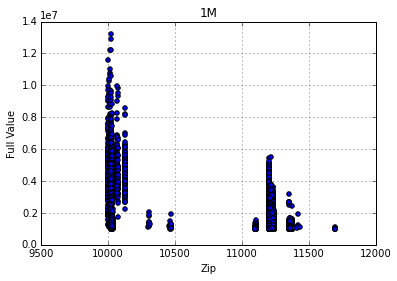

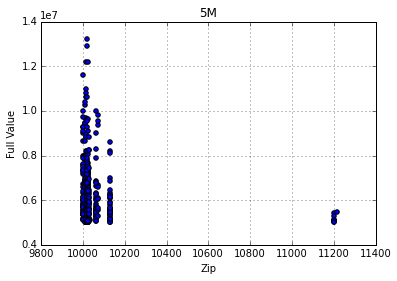

In [41]:
#df2010_houses[df2010_houses.Zip < 11300].plot(y="Full Value", x="Zip", kind="scatter")

df2010_houses[df2010_houses["Full Value"] >= 1e6].plot(y="Full Value", x="Zip", kind="scatter", title="1M")
df2010_houses[df2010_houses["Full Value"] >= 5e6].plot(y="Full Value", x="Zip", kind="scatter", title="5M")



In [42]:
df2010_houses.Owner.value_counts().head(20)

DEUTSCHE BANK NATIONA    299
NEW YORK CITY HOUSING    196
U.S. BANK NATIONAL AS    113
WELLS FARGO BANK, N.A     91
HSBC BANK USA, NATION     72
HOUSING PRESERVATION      66
FEDERAL NATIONAL MORT     60
SECRETARY OF HOUSING      56
NYC PARTNERSHIP HOUSI     54
FEDERAL HOME LOAN MOR     50
NYC HOUSING AUTHORITY     49
NYC PARTNERSHIP HDFC      47
RESTORED HOMES HOUSIN     34
US BANK NATIONAL ASSO     34
THE BANK OF NEW YORK      32
HSBC BANK USA, N.A.       30
CLINTON GRAHAM            29
WASHINGTON MUTUAL BAN     28
LASALLE BANK NATIONAL     28
M.S.B. DEVELOPMENT CO     26
dtype: int64

In [43]:
### ???????????????????????????????
### ???????????????????????????????
### ???????????????????????????????

zip_counts = df2010_subcols.Zip.value_counts() > 1000

#df2010_subcols[df2010_subcols.Zip.value_counts() > 1000]



# python client for enigma.io API - for now it just provides "export" support

In [31]:
#!/usr/bin/env python

import os
import sys
import time
import argparse
import requests
from requests import RequestException

ARGPARSER = argparse.ArgumentParser()
ARGPARSER.add_argument("datapath")
ARGPARSER.add_argument("-o", "--outfname", dest="outfname", required=False)


class EnigmaClient:
    ENIG_RETCODE_SUCCESS = 0
    ENIG_RETCODE_TIMEOUT = 1
    ENIG_RETCODE_ERROR   = 2

    _QUERY_TEMPLATE = "https://api.enigma.io/v2/{op}/{key}/{datapath}/{params}"
    _EXPORTAPI_MAX_SECS_TIMEOUT = 120
    _EXPORTAPI_POLL_SECS_INTERVAL = 1
    _EXPORTAPI_CHUNK_SIZE = 1024 * 64

    def __init__(self, apikey):
        self.apikey = apikey


    # Tables are exported as Gzipped CSV files. 
    # 
    # Exports of large tables may take some time, so exports are processed
    # asynchronously.
    # 
    # When the export API is called, an export is queued and the API immediately
    # returns a URL pointing to the future location of the exported file. Users
    # should poll the URL until the file becomes available.
    # 
    # Note: this is a synchronous call. Caller waits (up to max_secs_timeout)
    #       until data is made available by Enigma backend, and then downloaded.
    #       Caller should check err_code if the export fails.
    # 
    # Returns one of: ENIG_RETCODE_SUCCESS, ENIG_RETCODE_TIMEOUT, ENIG_RETCODE_ERROR
    # 
    def export(self, datapath, parameters=None,
               max_secs_timeout=None, outfname=None):

        query_str = self._QUERY_TEMPLATE.format(op="export", key=self.apikey,
                                                datapath=datapath, params="")
        # make a query, which sends back the URL that we'll have to poll
        # until it eventually responds back with the gzipped csv file.
        resp = requests.get(query_str)
        resp_json = resp.json()
        export_url = resp_json["export_url"]

        if not outfname:
            # derive it from the URL
            outfname = export_url[export_url.strip("/").rfind("/")+1:]
            if "?" in outfname:
                outfname = outfname[:outfname.rfind("?")]

        return self._download_file(export_url, outfname)
        
    def _download_file(self, export_url, outfname):
        timeout_secs_remaining = self._EXPORTAPI_MAX_SECS_TIMEOUT
        poll_time_interval = self._EXPORTAPI_POLL_SECS_INTERVAL

        completed = False
        print("About to attempt exporting export URL: {}".format(export_url))
        while (not completed) and (timeout_secs_remaining > 0):
            print("Retries timeout remaining: {} secs".format(timeout_secs_remaining))
            try:
                resp = requests.get(export_url, stream=True)
                if resp.ok is True:
                    with open(outfname, 'wb') as fout:
                        for chunk in resp.iter_content(
                                chunk_size=self._EXPORTAPI_CHUNK_SIZE): 
                            if chunk: # filter out keep-alive new chunks
                                fout.write(chunk)
                                fout.flush()
                    completed = True
                else:
                    print("Still polling. Response status_code: {} - Reason: {}".format(
                        resp.status_code, resp.reason))
            except Exception as exc:
                print("exc: {}".format(exc))
            finally:
                if not completed:
                    time.sleep(poll_time_interval)
                    timeout_secs_remaining -= poll_time_interval

        if completed is True:
            return self.ENIG_RETCODE_SUCCESS
        elif timeout_secs_remaining < 0:
            return self.ENIG_RETCODE_TIMEOUT
        else:
            return self.ENIG_RETCODE_ERROR

        
def main(apikey, args):
    # just getting started. For now there's only functionality to "export".
    client = EnigmaClient(apikey)
    client.export(args.datapath, outfname=args.outfname)


if __name__ == "__main__":
    apikey = os.getenv("ENV_ENIGMA_APIKEY")
    if not apikey:
        print('Please set your env var "ENV_ENIGMA_APIKEY"')
        sys.exit(1)
    
    main(apikey, ARGPARSER.parse_args())


Please set your env var "ENV_ENIGMA_APIKEY"


SystemExit: 1

To exit: use 'exit', 'quit', or Ctrl-D.
